# Gaussian Process Regression


Gaussian Process Regression (GPR) is a non-parametric approach to describe the relationships between variables without specifying the underlying distribution. By choosing Gaussian distributions to model the data, you benefit from their properties, for example that the marginal and conditional distributions are also Gaussian [1]. 


## Gaussian Process

A Gaussian Process (GP) is a generalization of a multivariate Gaussian distribution to infinite dimension and used to describe a distribution over functions. It defines a prior distribution over functions from which a posterior distribution can be inferred when data is observed.
A GP is completely specified by a mean function $m(x)$ and a covariance function $k(x,x')$ of a real process $f(x)$: $f(x) \sim GP(m(x),k(x,x'))$. Usually, the mean value is set to $m(x)=0$ since the GP is flexible enough to model the mean arbitrarily well.
The function values $f(x_1),...,f(x_n)$ are jointly Gaussian, corresponding to any number of input points $n$ [1,2,3]. 


## Kernels

Kernels are used as similarity measure between objects and define the covariance matrix $\Sigma$. A kernel $k$ is a positive definite kernel function and describes the shape of the distribution as well as characteristics of the function we want to predict. If two points $x$ and $x'$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too. The kernel function $k$ is a real-valued function of two arguments, $k(x,x') \in \mathbb{R}$. To retrieve the covariance matrix $\Sigma$, we evaluate $k$ on each pairwise combination of the set of points, $k: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R},~ \Sigma = Cov(X,X') = k(x,x')$.  
The most common kernel functions are the following:  

* Radial Basis Function (RBF): $K(x,x')= \sigma^2 exp(- \frac{||x-x'||^2}{2\ell^2}) $  
The RBF kernel is a stationary kernel, hence it is invariant to translations and the covariance between two points depends only on their relative positions. Scale factor $\sigma^2$ is the variance controling vertical variation, and describing the average distance of the function away from its mean. Parameter $\ell$ determines the horizontal lengthscale ober which the function varies, and determines the reach of influence on the neighbors. 


* Linear: $K(x,x') = \sigma_b^2 + \sigma^2(x-c)(x'-c)$  
The linear kernel is a non-stationary kernel, so the covariance between two points depends on their absolute positions. Parameter $c$ determines the point on which all posterior functions hinge. The constant variance $\sigma_b$ describes how far from 0 the height of the function will be at zero, hence adding an uncertain offset to the model [2,4].


## Prior

We define the prior as a GP over the test set $X_*$, where each test point is treated as a random variable. In our example, we choose $|X_*|=N=50$ linearly-spaced values from 0 to 15 as test set to get the prior $P_{X_*}$ before any data is observed. The prior has dimensionality $N$ and revolves around $\mu=0$. The covariance matrix $\Sigma_{**}$ is computed by applying the kernel function $k$ to the test points $X_*$. 
To demonstrate realizations of a GP we implement the prior distribution as previously described with following hyperparameters:  
* RBF: $\sigma^2 = 0.5,~ \ell = 0.8$  
* Linear: $\sigma^2 = 0.2,~ \sigma_b = 0.3,~ c = 0.7$  

and generate a random Gaussian vector $f_* \sim \mathcal{N}(\mu, k(X_*,X_*)) = \mathcal{N}(0,\Sigma_{**})$ to sample five functions from each Prior.

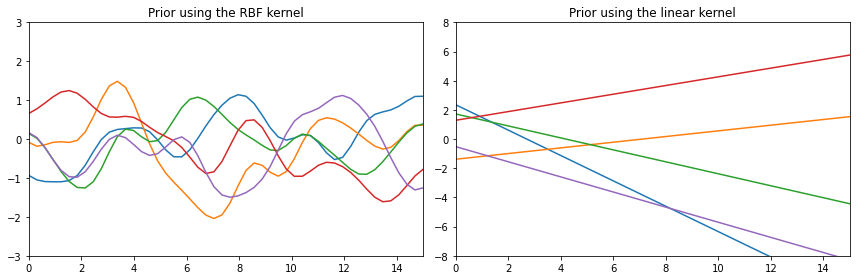

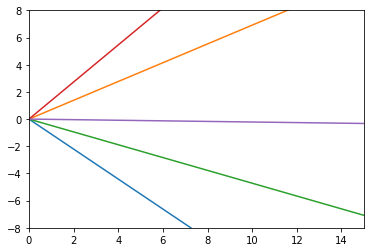

In [89]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt


# Test Data: N points from 0 to 10
N = 50
X_s = np.linspace(0, 15, N).reshape(-1,1)


# Kernel functions
def kernel_rbf(x, y, param):
    variance = param[0]
    lengthscale = param[1]
    # Euclidean distance between points
    eucdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return variance * np.exp(-0.5 * eucdist * 1/(lengthscale**2))
    
    
def kernel_linear(x, y, param):
    variance = param[0]
    variance_b = param[1]
    offset = param[2]
    return variance_b + variance * np.dot((x-offset), (y-offset).T)

def kernel_linear2(x, y, param):
    return param*np.dot(x, y.T)


# Prior using RBF kernel 
params_rbf = [0.5, 1] 
# Mean and Covariance of Prior
cov_ss_rbf = kernel_rbf(X_s, X_s, params_rbf)
mu_ss_rbf = np.zeros(X_s.shape)
# Sample 5 normals from the GP prior
f_s_rbf = np.random.multivariate_normal(mu_ss_rbf.ravel(), cov_ss_rbf, 5)
# Plot these samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for sample in f_s_rbf:
    ax1.plot(X_s, sample, lw=1.5, ls='-')
    ax1.axis([0, 15, -3, 3])
    ax1.set_title('Prior using the RBF kernel')
    

# Prior using Linear kernel
params_lin = [0.5, 2, 0.5]
cov_ss_lin = kernel_linear(X_s, X_s, params_lin)
mu_ss_lin = np.zeros(X_s.shape)
f_s_lin = np.random.multivariate_normal(mu_ss_lin.ravel(), cov_ss_lin, 5)
# Plot these samples
for sample in f_s_lin:
    ax2.plot(X_s, sample, lw=1.5, ls='-')
    ax2.axis([0, 15, -8, 8])
    ax2.set_title('Prior using the linear kernel')

plt.tight_layout()
plt.show()


cov_l2 = kernel_linear2(X_s, X_s, 1)
mu_l2 = np.zeros(X_s.shape)
f_l2 = np.random.multivariate_normal(mu_l2.ravel(), cov_l2, 5)
for sample in f_l2:
    plt.plot(X_s, sample, lw=1.5, ls='-')
    plt.axis([0, 15, -8, 8])


## Combination of kernels

## Observations

Now we want to incorporate knowledge from collected training data. First, we assume that we obtained perfect measurements and have noise-free observations. We get the training set $\{(x_i,f_i)|i=1,...,n\}$, consisting of inputs $X$ and function outputs $f$. 
Given our test set $X_*$ and our training data $\{X,~ f\}$, we want to predict the function outputs $f_*$.   
The joint distribution of training and test outputs is: $\begin{bmatrix} f \\ f_* \end{bmatrix} \sim \mathcal{N} \begin{pmatrix} \begin{bmatrix} \mu \\ \mu_* \end{bmatrix}, \begin{bmatrix} \Sigma & \Sigma_* \\ \Sigma_*^T & \Sigma_{**} \end{bmatrix} \end{pmatrix} $,  
where $\Sigma$ denotes the covariance matrix evaluated at all paris of test points, $\Sigma_*$ at training and test points, and $\Sigma_{**}$ at training points, and $\mu=\mu_*=0$.  

The posterior distribution $p(f_*|X_*,X,f)$ can be derived by conditioning the joint Gaussian prior distributions on the observations. We get:  

\begin{align}
f_*|X_*,X,f \sim \mathcal{N}(\Sigma_*^T \Sigma^{-1}f,~ \Sigma_{**} - \Sigma_*^T \Sigma^{-1} \Sigma_*) 
\label{eq:post}\tag{1}
\end{align}

The function values $f_*$ can be sampled from the joint posterior distribution by evaluating the mean and covariance matrix and generating samples. 

Our training data consists of $X=[2,3,5,10]$ and $f=[0.64,1.21,2.93,7.76]$. We now sample from the GP posterior after conditioning on the four mentioned observations. The shaded area represents the uncertainty as the $95\%$ confidence region (pointwise mean $\pm$ two times the standard deviation for each input value).  

Note that the variance is zero in a noise-free model, and that all functions go directly through the training points [2,5].

In [90]:
# computes mean vector mu_s and covariance matrix sigma_s for posterior distribution by applying equation (1)
def posterior(X, X_s, f, kernel=kernel_rbf, params=params_rbf):
    cov = kernel(X, X, params)
    cov_s = kernel(X, X_s, params)
    cov_ss = kernel(X_s, X_s, params)
    
    mu_s = cov_s.T.dot(np.linalg.inv(cov)).dot(f)
    sigma_s = cov_ss - cov_s.T.dot(np.linalg.inv(cov)).dot(cov_s)
    
    return mu_s, sigma_s


# adapted from https://github.com/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_util.py
# to plot GPs with mean value and uncertainty area
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[], ax0=plt):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    ax0.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.2)
    ax0.plot(X, mu, '--', color='darkblue', lw=2, label='Mean')
    for i, sample in enumerate(samples):
        ax0.plot(X, sample, lw=1.5, label=f'Sample {i+1}')
    if X_train is not None:
        ax0.plot(X_train, Y_train, 'o', ms=8, color='darkblue')
    ax0.legend()


# Noise free Training data
X = np.array([2,3,5,10]).reshape(-1,1)
f = np.array([0.64,1.21,2.93,7.76]).reshape(-1,1)


# Compute mean and covariance of the posterior distribution and draw 5 samples
mu_s, cov_s = posterior(X, X_s, f, kernel_rbf, params_rbf)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 5)

mu_sl, cov_sl = posterior(X, X_s, f, kernel=kernel_linear, params=params_lin)
samplesl = np.random.multivariate_normal(mu_sl.ravel(), cov_sl, 5)


# Plot these samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_gp(mu_s, cov_s, X_s, X, f, samples, ax1)
plot_gp(mu_sl, cov_sl, X_s, X, f, samplesl, ax2)





LinAlgError: Singular matrix

## Kernel parameters

Choosing the hyperparameters of the kernels has an effect on the functions we draw from the GP.  
RBF: Higher $\ell$ values lead to smoother functions and therefore coarser approximations of the training data. $\sigma$ controls the vertical variation of the function. 

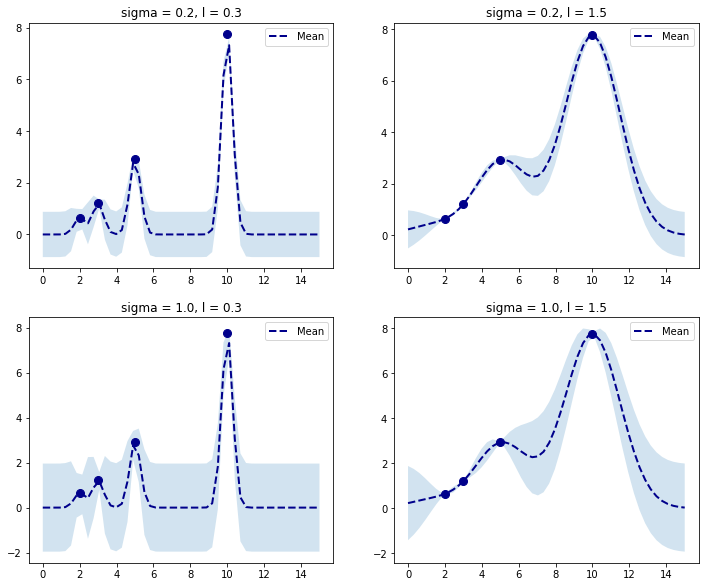

In [76]:
params = [
    (0.2, 0.3),
    (0.2, 1.5),
    (1.0, 0.3),
    (1.0, 1.5)
]

plt.figure(figsize=(12, 4))

for i, (var, l) in enumerate(params):
    mu_s, cov_s = posterior(X, X_s, f, kernel_rbf, 
                            params=[var,l])
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'sigma = {var}, l = {l}')
    plot_gp(mu_s, cov_s, X_s, X, f)

## Noisy Observations

Normally, we do not have perfect data, but some noise available due to measurement errors, for example. In this case, the training points are only approximated and the variance is not zero at those training points.

--> Später

# References

[1] Jochen  Görtler,  Rebecca  Kehlbeck,  and  Oliver  Deussen.   A  visual  exploration  of gaussian processes. Distill, 4:e17, 2019.  
[2] Kevin P. Murphy. Machine Learning: a probabilistic perspective.  MIT press, 2012.   
[3] Rasmussen, Carl Edward. Gaussian processes in machine learning. In Summer school on machine learning, Springer, 2003.  
[4] https://www.cs.toronto.edu/~duvenaud/cookbook/  
[5] https://krasserm.github.io/2018/03/19/gaussian-processes/